# Crime map of Monreal Island

### Data fetched form [OPEN DATA PORTAL(City of Montreal)](http://donnees.ville.montreal.qc.ca/dataset)

In [2]:
import pandas as pd
csv_file = 'mtl_crime'
df = pd.read_csv(csv_file, encoding='latin-1', parse_dates = ['DATE'])
df.DATE = pd.to_datetime(df.DATE, format='%Y-%m-%d')
print(df.head())
print(df['DATE'].max())
print(df['DATE'].min())

                  CATEGORIE       DATE QUART   PDQ              X  \
0  Vol de véhicule à moteur 2018-09-13  jour  30.0  294904.159001   
1  Vol de véhicule à moteur 2018-04-30  jour  30.0  294904.159001   
2  Vol de véhicule à moteur 2018-09-01  nuit   7.0  290274.565000   
3                    Méfait 2017-07-21  jour  21.0       0.000000   
4                    Méfait 2017-07-29  jour  12.0       0.000000   

              Y  LONGITUDE   LATITUDE  
0  5.047549e+06 -73.626778  45.567780  
1  5.047549e+06 -73.626778  45.567780  
2  5.042150e+06 -73.685928  45.519122  
3  0.000000e+00   1.000000   1.000000  
4  0.000000e+00   1.000000   1.000000  
2019-08-30 00:00:00
2015-01-01 00:00:00


### Crime trend

In [3]:
df['YEAR'] = df['DATE'].map(lambda x: x.year)
df['MONTH'] = df['DATE'].map(lambda x: x.month)

In [5]:
# extract incident number of each year of different categroies
# Function to divide df into different year
def crime_year(dataframe = df, year = 2016):
    df_year = dataframe[dataframe['YEAR'] == year]
    return df_year

In [8]:
for i in range(2015,2020):
    globals()['df_%s' % i] = crime_year(year=i)
df_2015.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 35609 entries, 117 to 117376
Data columns (total 10 columns):
CATEGORIE    35609 non-null object
DATE         35609 non-null datetime64[ns]
QUART        35609 non-null object
PDQ          35609 non-null float64
X            35609 non-null float64
Y            35609 non-null float64
LONGITUDE    35609 non-null float64
LATITUDE     35609 non-null float64
YEAR         35609 non-null int64
MONTH        35609 non-null int64
dtypes: datetime64[ns](1), float64(5), int64(2), object(2)
memory usage: 3.0+ MB


In [2]:
# Check the completeness of the dataframe
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 147426 entries, 0 to 147425
Data columns (total 8 columns):
CATEGORIE    147426 non-null object
DATE         147426 non-null datetime64[ns]
QUART        147426 non-null object
PDQ          147422 non-null float64
X            147426 non-null float64
Y            147426 non-null float64
LONGITUDE    147426 non-null float64
LATITUDE     147426 non-null float64
dtypes: datetime64[ns](1), float64(5), object(2)
memory usage: 9.0+ MB


In [3]:
# Check unique value in "CATEGORIE" column
crime_category = df['CATEGORIE'].unique().tolist()
print(crime_category)

['Vol de véhicule à moteur', 'Méfait', 'Vols qualifiés', 'Vol dans / sur véhicule à moteur', 'Introduction', 'Infractions entrainant la mort']


English translation:
'Vehicle theft', 'Mischief', 'Robbery', 'Theft from a motor vehicle', 'Break-in', 'Offenses causing death'

In [4]:
# Covert DataFrame to GeoDataFrame
import geopandas as gpd
from shapely.geometry import Point

geometry = [Point(xy) for xy in zip(df.LONGITUDE, df.LATITUDE)]
df1 = df.drop(['LONGITUDE', 'LATITUDE','X'], axis=1)
crs = {'init': 'epsg:4326'}
gdf = gpd.GeoDataFrame(df1, crs=crs, geometry=geometry)
print(gdf.head())

                  CATEGORIE       DATE QUART   PDQ             Y  \
0  Vol de véhicule à moteur 2018-09-13  jour  30.0  5.047549e+06   
1  Vol de véhicule à moteur 2018-04-30  jour  30.0  5.047549e+06   
2  Vol de véhicule à moteur 2018-09-01  nuit   7.0  5.042150e+06   
3                    Méfait 2017-07-21  jour  21.0  0.000000e+00   
4                    Méfait 2017-07-29  jour  12.0  0.000000e+00   

                               geometry  
0   POINT (-73.6267780469 45.567779813)  
1   POINT (-73.6267780469 45.567779813)  
2  POINT (-73.6859284522 45.5191216465)  
3                           POINT (1 1)  
4                           POINT (1 1)  


In [5]:
# Clean the void geometry data e.g., POINT (1 1)
gdf1 = gdf.loc[gdf['Y']!= 0]
print(gdf1.head())
gdf1.info()

                          CATEGORIE       DATE QUART   PDQ             Y  \
0          Vol de véhicule à moteur 2018-09-13  jour  30.0  5.047549e+06   
1          Vol de véhicule à moteur 2018-04-30  jour  30.0  5.047549e+06   
2          Vol de véhicule à moteur 2018-09-01  nuit   7.0  5.042150e+06   
6                            Méfait 2017-07-30  jour  38.0  5.041877e+06   
8  Vol dans / sur véhicule à moteur 2017-08-01  jour  39.0  5.051450e+06   

                                  geometry  
0      POINT (-73.6267780469 45.567779813)  
1      POINT (-73.6267780469 45.567779813)  
2     POINT (-73.6859284522 45.5191216465)  
6  POINT (-73.591457265 45.51677617359999)  
8     POINT (-73.6351174956 45.6028733349)  
<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 121521 entries, 0 to 147204
Data columns (total 6 columns):
CATEGORIE    121521 non-null object
DATE         121521 non-null datetime64[ns]
QUART        121521 non-null object
PDQ          121521 non-null float64
Y 

In [6]:
#define the heatmap function which takes a GeoDataFrame with point geometries. 
#Using numpy's 2D histogram binning with smoothing from scipy.
import numpy as np
import matplotlib.pylab as pylab
import matplotlib.pyplot as plt
from scipy import ndimage


def heatmap(d, bins=(100,100), smoothing=1.3, cmap='jet', alpha=0.9
            , x_limit = (-73.9,-73.5), y_limit = (45.42, 45.7),c_limit = (0,1.6)
           , fname = 'heatmap'):
    def getx(pt):
        return pt.coords[0][0]

    def gety(pt):
        return pt.coords[0][1]
    
    x = list(d.geometry.apply(getx))
    y = list(d.geometry.apply(gety))
    heatmap, xedges, yedges = np.histogram2d(y, x, bins=bins)
    extent = [yedges[0], yedges[-1], xedges[-1], xedges[0]]

    logheatmap = np.log(heatmap)
    logheatmap[np.isneginf(logheatmap)] = 0
    logheatmap = ndimage.filters.gaussian_filter(logheatmap, smoothing, mode='nearest')
    
    plt.imshow(logheatmap, cmap=cmap, extent=extent, alpha=alpha)
    #plt.colorbar()
    plt.gca().invert_yaxis()
    plt.xlim(x_limit)
    plt.ylim(y_limit)
    plt.clim(c_limit)
    plt.savefig(fname, dpi=300)

C:\Users\li_au\Anaconda3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: divide by zero encountered in log


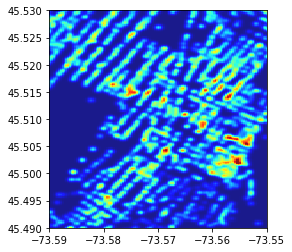

In [7]:
hm_dt = heatmap(gdf1, bins= (1500, 1500), smoothing=1.5
                , x_limit = (-73.59,-73.55), y_limit = (45.49, 45.53), c_limit = (0,0.6)
               ,fname = 'heatmap_dt_test')

In [8]:
# define the boundary of the map
from shapely.geometry import Polygon

lon_point_list = [-73.59, -73.55, -73.55, -73.59, -73.59]
lat_point_list = [45.49, 45.49, 45.53, 45.53,45.53]


polygon_geom = Polygon(zip(lon_point_list, lat_point_list))
crs = {'init': 'epsg:4326'}

polygon = gpd.GeoDataFrame(index=[0], crs=crs, geometry=[polygon_geom])       
print(polygon)

polygon.to_file(filename='boundary.shp', driver="ESRI Shapefile")
polygon.to_file(filename='boundary.geojson', driver='GeoJSON')

                                            geometry
0  POLYGON ((-73.59 45.49, -73.55 45.49, -73.55 4...


In [9]:
import folium
m = folium.Map([45.5055, -73.5743], zoom_start=13, tiles='cartodbpositron')
folium.GeoJson(polygon).add_to(m)
folium.LatLngPopup().add_to(m)
m

In [10]:
crime_dt = gpd.sjoin(gdf1, polygon, how='left')

In [11]:
crime_dt_filtered = crime_dt[crime_dt.index_right == 0.0].copy()
crime_dt_filtered

,CATEGORIE,DATE,QUART,PDQ,Y,geometry,index_right
17,Vols qualifiés,2017-08-02,soir,21.0,5.041903e+06,POINT (-73.559521738 45.51703068770001),0.0
18,Introduction,2017-08-03,jour,22.0,5.042438e+06,POINT (-73.5550997957 45.5218477274),0.0
27,Méfait,2017-08-23,jour,12.0,5.038914e+06,POINT (-73.5835927935 45.490119618),0.0
33,Vol dans / sur véhicule à moteur,2018-09-05,jour,38.0,5.042566e+06,POINT (-73.58794455479999 45.5229743869),0.0
34,Vol dans / sur véhicule à moteur,2017-08-25,jour,22.0,5.042710e+06,POINT (-73.5528028932 45.5242964845),0.0
38,Introduction,2018-02-17,jour,21.0,5.041020e+06,POINT (-73.55334174630001 45.5090880326),0.0
39,Vol dans / sur véhicule à moteur,2018-10-28,jour,21.0,5.041020e+06,POINT (-73.55334174630001 45.5090880326),0.0
43,Introduction,2017-09-13,nuit,21.0,5.041929e+06,POINT (-73.5593055777 45.5172635889),0.0
49,Introduction,2016-07-30,jour,38.0,5.040863e+06,POINT (-73.5716866993 45.5076658438),0.0
105,Introduction,2016-10-12,jour,22.0,5.042710e+06,POINT (-73.5528028932 45.5242964845),0.0


In [12]:
# export geodataframes as shapefile
crime_dt_filtered['timestamp'] = crime_dt_filtered['DATE'].apply(lambda x: str(x))
crime_dt_filtered

,CATEGORIE,DATE,QUART,PDQ,Y,geometry,index_right,timestamp
17,Vols qualifiés,2017-08-02,soir,21.0,5.041903e+06,POINT (-73.559521738 45.51703068770001),0.0,2017-08-02 00:00:00
18,Introduction,2017-08-03,jour,22.0,5.042438e+06,POINT (-73.5550997957 45.5218477274),0.0,2017-08-03 00:00:00
27,Méfait,2017-08-23,jour,12.0,5.038914e+06,POINT (-73.5835927935 45.490119618),0.0,2017-08-23 00:00:00
33,Vol dans / sur véhicule à moteur,2018-09-05,jour,38.0,5.042566e+06,POINT (-73.58794455479999 45.5229743869),0.0,2018-09-05 00:00:00
34,Vol dans / sur véhicule à moteur,2017-08-25,jour,22.0,5.042710e+06,POINT (-73.5528028932 45.5242964845),0.0,2017-08-25 00:00:00
38,Introduction,2018-02-17,jour,21.0,5.041020e+06,POINT (-73.55334174630001 45.5090880326),0.0,2018-02-17 00:00:00
39,Vol dans / sur véhicule à moteur,2018-10-28,jour,21.0,5.041020e+06,POINT (-73.55334174630001 45.5090880326),0.0,2018-10-28 00:00:00
43,Introduction,2017-09-13,nuit,21.0,5.041929e+06,POINT (-73.5593055777 45.5172635889),0.0,2017-09-13 00:00:00
49,Introduction,2016-07-30,jour,38.0,5.040863e+06,POINT (-73.5716866993 45.5076658438),0.0,2016-07-30 00:00:00
105,Introduction,2016-10-12,jour,22.0,5.042710e+06,POINT (-73.5528028932 45.5242964845),0.0,2016-10-12 00:00:00


In [13]:
crime_dt_filtered_2 = crime_dt_filtered.drop(['DATE','Y', 'PDQ','index_right'], axis = 1)
crime_dt_filtered_2

,CATEGORIE,QUART,geometry,timestamp
17,Vols qualifiés,soir,POINT (-73.559521738 45.51703068770001),2017-08-02 00:00:00
18,Introduction,jour,POINT (-73.5550997957 45.5218477274),2017-08-03 00:00:00
27,Méfait,jour,POINT (-73.5835927935 45.490119618),2017-08-23 00:00:00
33,Vol dans / sur véhicule à moteur,jour,POINT (-73.58794455479999 45.5229743869),2018-09-05 00:00:00
34,Vol dans / sur véhicule à moteur,jour,POINT (-73.5528028932 45.5242964845),2017-08-25 00:00:00
38,Introduction,jour,POINT (-73.55334174630001 45.5090880326),2018-02-17 00:00:00
39,Vol dans / sur véhicule à moteur,jour,POINT (-73.55334174630001 45.5090880326),2018-10-28 00:00:00
43,Introduction,nuit,POINT (-73.5593055777 45.5172635889),2017-09-13 00:00:00
49,Introduction,jour,POINT (-73.5716866993 45.5076658438),2016-07-30 00:00:00
105,Introduction,jour,POINT (-73.5528028932 45.5242964845),2016-10-12 00:00:00


In [14]:
import fiona
crime_dt_filtered_2.to_file("crime_dt.shp")

In [15]:
import geopandas as gpd
from shapely.geometry import Polygon
import numpy as np
points = gpd.read_file('crime_dt.shp')

xmin,ymin,xmax,ymax = points.total_bounds

wide = 0.002
hight = 0.002


cols = list(np.arange(xmin, xmax, wide))
rows = list(np.arange(ymin, ymax, hight))
rows.reverse()

polygons = []
for x in cols:
    for y in rows:
        polygons.append( Polygon([(x,y), (x+wide, y), (x+wide, y-hight), (x, y-hight)]) )

grid = gpd.GeoDataFrame({'geometry':polygons})
grid.to_file("grid.shp")

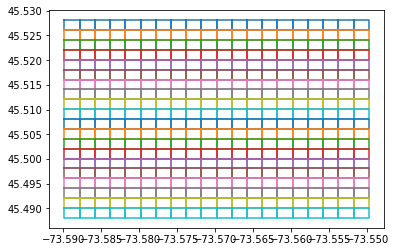

In [16]:
import shapefile as shp  # Requires the pyshp package
import matplotlib.pyplot as plt

sf = shp.Reader("grid.shp")

plt.figure()
for shape in sf.shapeRecords():
    x = [i[0] for i in shape.shape.points[:]]
    y = [i[1] for i in shape.shape.points[:]]
    plt.plot(x,y)
plt.show()

In [17]:
grid.head()

,geometry
0,POLYGON ((-73.58983070149999 45.52806850850005...
1,POLYGON ((-73.58983070149999 45.52606850850005...
2,POLYGON ((-73.58983070149999 45.52406850850004...
3,POLYGON ((-73.58983070149999 45.52206850850004...
4,POLYGON ((-73.58983070149999 45.52006850850004...


In [18]:
grid.crs = {'init': 'epsg:4326'}

#https://stackoverflow.com/questions/27606924/count-number-of-points-in-multipolygon-shapefile-using-python

polygons = gpd.GeoDataFrame.from_file('grid.shp')
points = gpd.GeoDataFrame.from_file('crime_dt.shp')

pts = points.copy() 

# We're going to keep a list of how many points we find.
pts_in_polys = []

# Loop over polygons with index i.
for i, poly in polygons.iterrows():

    # Keep a list of points in this poly
    pts_in_this_poly = []

    # Now loop over all points with index j.
    for j, pt in pts.iterrows():
        if poly.geometry.contains(pt.geometry):
            # Then it's a hit! Add it to the list,
            # and drop it so we have less hunting.
            pts_in_this_poly.append(pt.geometry)
            pts = pts.drop([j])

    # We could do all sorts, like grab a property of the
    # points, but let's just append the number of them.
    pts_in_polys.append(len(pts_in_this_poly))

# Add the number of points for each poly to the dataframe.
polygons['number of points'] = gpd.GeoSeries(pts_in_polys)

In [19]:
polygons

,FID,geometry,number of points
0,0,POLYGON ((-73.58983070149999 45.52806850850005...,67
1,1,POLYGON ((-73.58983070149999 45.52606850850005...,38
2,2,POLYGON ((-73.58983070149999 45.52406850850004...,40
3,3,POLYGON ((-73.58983070149999 45.52206850850004...,44
4,4,POLYGON ((-73.58983070149999 45.52006850850004...,23
5,5,POLYGON ((-73.58983070149999 45.51806850850004...,30
6,6,POLYGON ((-73.58983070149999 45.51606850850003...,0
7,7,POLYGON ((-73.58983070149999 45.51406850850003...,0
8,8,POLYGON ((-73.58983070149999 45.51206850850003...,0
9,9,POLYGON ((-73.58983070149999 45.51006850850003...,0


In [20]:
polygons.describe()

,FID,number of points
count,400.000000,400.000000
mean,199.500000,46.207500
std,115.614301,48.546745
min,0.000000,0.000000
25%,99.750000,7.500000
50%,199.500000,32.000000
75%,299.250000,65.000000
max,399.000000,270.000000


In [27]:
# https://stackoverflow.com/questions/44991438/lambda-including-if-elif-else
polygons['risk'] = polygons['number of points'].apply(lambda x: 1 if x > 65 else (0))    

In [28]:
polygons

,FID,geometry,number of points,risk
0,0,POLYGON ((-73.58983070149999 45.52806850850005...,67,1
1,1,POLYGON ((-73.58983070149999 45.52606850850005...,38,0
2,2,POLYGON ((-73.58983070149999 45.52406850850004...,40,0
3,3,POLYGON ((-73.58983070149999 45.52206850850004...,44,0
4,4,POLYGON ((-73.58983070149999 45.52006850850004...,23,0
5,5,POLYGON ((-73.58983070149999 45.51806850850004...,30,0
6,6,POLYGON ((-73.58983070149999 45.51606850850003...,0,0
7,7,POLYGON ((-73.58983070149999 45.51406850850003...,0,0
8,8,POLYGON ((-73.58983070149999 45.51206850850003...,0,0
9,9,POLYGON ((-73.58983070149999 45.51006850850003...,0,0


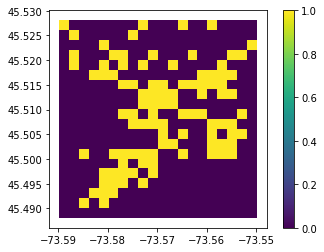

In [29]:
fig, ax = plt.subplots(1, 1)
polygons.plot(column='risk', ax=ax, legend=True)

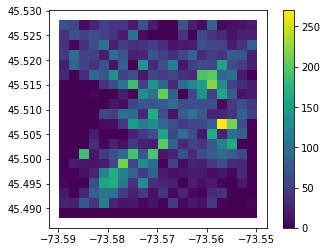

In [30]:
fig, ax = plt.subplots(1, 1)
polygons.plot(column='number of points', ax=ax, legend=True)